In [5]:
import os
import pandas as pd
import random
import cv2
import numpy as np
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import math 
%matplotlib inline
from coreLib.core import *
data_path       = "/media/ansary/DriveData/Work/bengalAI/datasets/source/"
raw_path        = os.path.join(data_path,'RAW')
raw_nums_path   = os.path.join(data_path,'RAW_NUMS')

from IPython.display import display,HTML

# CreateLabeledImage Debug
```python
def createLabeledImage(raw_path,
                       raw_nums_path,
                       nimg):
    '''
        takes the config defined as the base parameter 
        args:
            raw_path        : directory that contains the raw grapheme images
            raw_nums_path   : directory that contains the raw number images
            nimg            : the identifier of an image
    '''
```
* plot and print step by step for more clear view

Randomly Selected Number of Lines:2
Randomly Selected Number of word:1 in line:0
Randomly Chosen data type for line0 is:['date']
Randomly Chosen Height for each word/number in line:0 is:40
Raw Line image for line:0


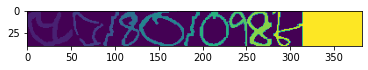

Randomly Selected Number of word:2 in line:1
Randomly Chosen data type for line1 is:['word', 'number']
Randomly Chosen Height for each word/number in line:1 is:72
Raw Line image for line:1


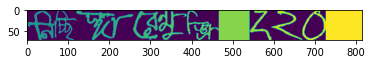

Resized Line image for line:0


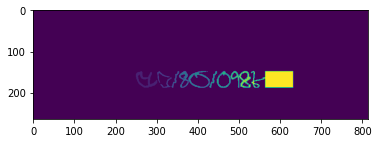

Resized Line image for line:1


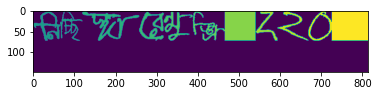

The concateneted page image


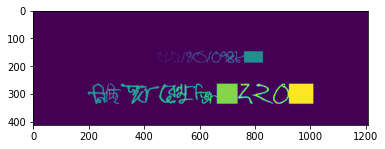

The page annotation for each letter/number and their bboxes in each line


,ImageId,LineNumber,IdenValue,Label,Coords
0,0,0,1,5,"[[447.0, 148.0], [498.0, 148.0], [498.0, 187.0], [447.0, 187.0]]"
1,0,0,2,5,"[[499.0, 148.0], [533.0, 148.0], [533.0, 187.0], [499.0, 187.0]]"
2,0,0,3,/,"[[534.0, 148.0], [551.0, 148.0], [551.0, 187.0], [534.0, 187.0]]"
3,0,0,4,4,"[[552.0, 148.0], [574.0, 148.0], [574.0, 187.0], [552.0, 187.0]]"
4,0,0,5,0,"[[575.0, 148.0], [625.0, 148.0], [625.0, 187.0], [575.0, 187.0]]"
5,0,0,6,/,"[[626.0, 148.0], [643.0, 148.0], [643.0, 187.0], [626.0, 187.0]]"
6,0,0,7,0,"[[644.0, 148.0], [676.0, 148.0], [676.0, 187.0], [644.0, 187.0]]"
7,0,0,8,7,"[[677.0, 148.0], [697.0, 148.0], [697.0, 187.0], [677.0, 187.0]]"
8,0,0,9,4,"[[698.0, 148.0], [725.0, 148.0], [725.0, 187.0], [698.0, 187.0]]"
9,0,0,10,8,"[[727.0, 148.0], [760.0, 148.0], [760.0, 187.0], [727.0, 187.0]]"


The Final page image


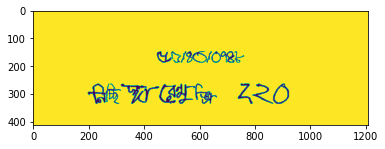

In [9]:
iden_val=1
nimg=0    
page_anon=[]
page_parts=[]
# select number of lines in an image
num_lines=random.randint(CONFIG.MIN_NUM_LINES,
                         CONFIG.MAX_NUM_LINES)

print(f"Randomly Selected Number of Lines:{num_lines}")

for nl in range(num_lines):
    line_parts=[]
    # select number of words
    num_words=random.randint(CONFIG.MIN_NUM_WORDS,
                             CONFIG.MAX_NUM_WORDS)
    print(f"Randomly Selected Number of word:{num_words} in line:{nl}")

    # randomly choose what type of data we want
    _types=random.choices(population=["number", "date", "word"],
                          weights=[0.2, 0.1, 0.7],
                          k=num_words)
    print(f"Randomly Chosen data type for line{nl} is:{_types}")

    # select a random height
    CONFIG.SYM_HEIGHT=random.choice(CONFIG.SYM_HEIGHTS)
    print(f"Randomly Chosen Height for each word/number in line:{nl} is:{CONFIG.SYM_HEIGHT}")

    
    for tidx,_type in enumerate(_types):
        if _type=="word":
            # select a random length
            word_len=random.randint(CONFIG.MIN_WORD_LEN,
                                    CONFIG.MAX_WORD_LEN)
            # create data                        
            _data,iden_val=createWordImage(word_len,raw_path,iden_val)
        elif _type=="number":
            # select a random length
            number_len=random.randint(CONFIG.MIN_NUM_LEN,
                                      CONFIG.MAX_NUM_LEN)
            # create data
            _data,iden_val=createNumberImage(number_len,raw_nums_path,iden_val)
        elif _type=="date":
            # select a random length
            year_len=random.choice([2,4])
            # create data
            _data,iden_val=createDateImage(year_len,raw_nums_path,iden_val)

        # create the part: word number etc image
        part_imgs=[]
        for part in _data:
            _img   = part[0]
            _label = part[1]
            _iden  = part[2]
            _line  = nl
            _img_id= nimg
            page_anon.append({"ImageId":_img_id,
                              "LineNumber":_line,
                              "IdenValue":_iden,
                              "Label":_label})
            part_imgs.append(_img)

        # all parts are paded
        if tidx <len(_types):
            # add pad 
            part_pad=np.ones((CONFIG.SYM_HEIGHT,
                              random.randint(CONFIG.HORZ_MIN_SPACE,
                                             CONFIG.HORZ_MAX_SPACE)),dtype=np.int64)*iden_val
            page_anon.append({"ImageId":_img_id,
                              "LineNumber":_line,
                              "IdenValue":iden_val,
                              "Label":" "})
            # increase iden
            iden_val+=1
            # complete part img    
            part_imgs.append(part_pad)
        # the part image
        part_img=np.concatenate(part_imgs,axis=1)
        # append
        line_parts.append(part_img)
    # create the line image
    line_img=np.concatenate(line_parts,axis=1)
    print(f"Raw Line image for line:{nl}")
    plt.imshow(line_img)
    plt.show()
    # the page lines
    page_parts.append(line_img)


# find max line width
max_line_width=0
for line in page_parts:
    _,w=line.shape
    if w>=max_line_width:
        max_line_width=w

# pad each line to max_width
paded_parts=[]
for lidx,line_img in enumerate(page_parts):
    line_img=padLineLeftRight(max_line_width,line_img)
    # top pad for first one
    if lidx==0:
        pad_height_top=random.randint(CONFIG.VERT_MIN_SPACE,
                                      CONFIG.VERT_MAX_SPACE*2)
        pad_top=np.zeros((pad_height_top,max_line_width))
        line_img=np.concatenate([pad_top,line_img],axis=0)
    # pad lines 
    pad_height=random.randint(CONFIG.VERT_MIN_SPACE,
                              CONFIG.VERT_MAX_SPACE)
    pad     =np.zeros((pad_height,max_line_width))
    line_img=np.concatenate([line_img,pad],axis=0)
    print(f"Resized Line image for line:{lidx}")
    
    plt.imshow(line_img)
    plt.show()
    
    paded_parts.append(line_img)
# page img
page_img=np.concatenate(paded_parts,axis=0)
h_pad,_=page_img.shape
_pad=np.zeros((h_pad,random.randint(CONFIG.VERT_MIN_SPACE,CONFIG.VERT_MAX_SPACE*2)),dtype=np.int64)
page_img=np.concatenate([_pad,page_img,_pad],axis=1)
print("The concateneted page image")
plt.imshow(page_img)
plt.show()
# page anon
page_anon=pd.DataFrame(page_anon)
# add coords
COORDS=[]
for i in page_anon.IdenValue.tolist():
    try:
        idx = np.where(page_img==i)
        y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
        x1,x2,x3,x4=x_min,x_max,x_max,x_min
        y1,y2,y3,y4=y_min,y_min,y_max,y_max
        coords=np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]],dtype="float32")
        COORDS.append(coords)
    except Exception as e:
        print(i,e)
page_anon["Coords"]=COORDS
print("The page annotation for each letter/number and their bboxes in each line")
display(HTML(page_anon.to_html()))
# shape image

df_space=page_anon.loc[page_anon.Label==' ']
space_vals=df_space.IdenValue.tolist()
for sv in space_vals:
    page_img[page_img==sv]=0
page_img[page_img>0]=255
page_img=page_img.astype("uint8")
page_img=255-page_img
print("The Final page image")
plt.imshow(page_img)
plt.show()


# Final Image Creation Debug

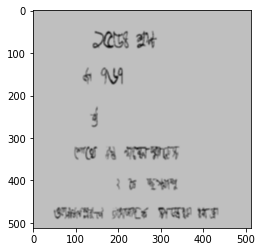

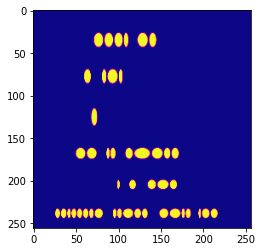

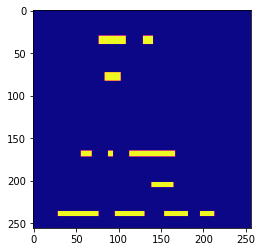

,ImageId,LineNumber,IdenValue,Label,Coords
0,0,0,1,1,"[[140.73802, 50.18561], [165.25012, 50.18561],..."
1,0,0,2,5,"[[165.52554, 50.18561], [188.66057, 50.18561],..."
2,0,0,3,5,"[[188.93597, 50.18561], [211.24475, 50.18561],..."
3,0,0,4,4,"[[211.52017, 50.18561], [223.6385, 50.18561], ..."
4,0,0,5,,"[[223.91393, 50.18561], [242.64227, 50.18561],..."
5,0,0,6,শ্যু,"[[242.9177, 50.18561], [270.45938, 50.18561], ..."
6,0,0,7,ণ্ট,"[[270.7348, 50.18561], [289.73856, 50.18561], ..."
7,0,0,8,,"[[290.01398, 50.18561], [316.7294, 50.18561], ..."
8,0,1,9,র্জা,"[[117.878426, 135.60793], [136.05594, 135.6079..."
9,0,1,10,,"[[136.33136, 135.60793], [160.01721, 135.60793..."


In [68]:
img,df,textmap,linkmap=create_single_data(raw_path,raw_nums_path,0)
plt.imshow(img)
plt.show()
plt.imshow(textmap,cmap="plasma")
plt.show()
plt.imshow(linkmap,cmap="plasma")
plt.show()

df


In [ ]:
dd=df.Coords.tolist()[0]
print(dd)
x1,y1=dd[0][0],dd[0][1]
x2,y2=dd[1][0],dd[1][1]
x3,y3=dd[2][0],dd[2][1]
x4,y4=dd[3][0],dd[3][1]
plt.imshow(img)
plt.plot([x1], [y1], marker="o", markersize=4)
plt.plot([x2], [y2], marker="o", markersize=4)
plt.plot([x3], [y3], marker="o", markersize=4)
plt.plot([x4], [y4], marker="o", markersize=4)
plt.show()

# Gaussian Heatmap Debug

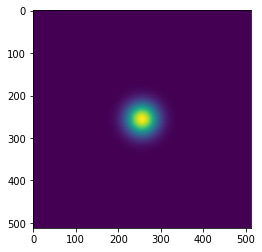

In [66]:
def get_gaussian_heatmap(size=512, distanceRatio=1.5):
    '''
        creates a gaussian heatmap
        This is a fixed operation to create heatmaps
    '''
    # distrivute values
    v = np.abs(np.linspace(-size / 2, size / 2, num=size))
    # create a value mesh grid
    x, y = np.meshgrid(v, v)
    # spreading heatmap
    g = np.sqrt(x**2 + y**2)
    g *= distanceRatio / (size / 2)
    g = np.exp(-(1 / 2) * (g**2))
    g *= 255
    return g.clip(0, 255).astype('uint8')
# fixed heatmap
heatmap_text=get_gaussian_heatmap(size=CONFIG.DATA_DIM,distanceRatio=10)
plt.imshow(heatmap_text)
plt.show()